# How can a robot decide wether it sees a cat or a dog?


## Using Logistic Regression for image classification

A new intern at Happy Paws animal rescue centre forgot to lock all the kennels from the cat and dog subdivisions after feeding them for the night.

The next day, when the shelter's employees arrived, they were surprised to find out that all the animals had escaped and were roaming freely in the centre. **Marty, the intern, decided to make up for this mishap by building a robot, Felix, to help put back all pets in their respective kennels.**

Marty is a second-year Computer Science student and knows that to train the robot for this task, a huge amount of cat and dog images are required. Thankfully, this type of images is freely available on Kaggle, an online community of data scientists and machine learners.

You can have a look at these images at https://www.kaggle.com/c/dogs-vs-cats.



<img src="https://i.imgur.com/KbkyNlE.png" style="height:350px">

<div>Credits: Image made using icons by <a href="https://www.flaticon.com/authors/smashicons" title="Smashicons">Smashicons</a> and <a href="https://www.flaticon.com/authors/freepik" title="Freepik">Freepik</a> from <a href="https://www.flaticon.com/" title="Flaticon">www.flaticon.com</a></div>



## How do computers "see" images?

<img src="https://i.imgur.com/aDtRM6j.png" style="height:350px">


<div>Original Totoro Credits: pattern image taken from <a href="https://kandipatterns.com" title="Kandipatterns">Kandipatterns</a> </a></div>



Digital images are stored as **a combination of pixels** made of a different number of channels. Grayscale images have only one channel, whereas coloured images, have three channels: **red (R), green (G) and blue (B)**.


<img src="https://i.imgur.com/xS13u7p.png" style="height:350px">

As humans need to be trained to perform a particular skill, computers need to train the machine learning model as well.

In both cases, training happens by examples. Similar to how you can teach somebody to identify a cat, you can teach your model how to identify a cat in an image by giving **several example images that contain the animal**. 

From these example images, the model learning features of the cat. These **features** can be related to its shape, color, proportions, etc. 

Now when a new image of a cat is presented to this computer with the trained model, it can use what it had learned earlier and identify that this new image also contains a cat.

**In this interactive Notebook we will use Logistic Regression to create and train a model that will help us differentiate cat images from dog images.**

## Preparing your tools

Before starting preparing a model for our robot we need to make sure we have all the tools we need. In the next code chunk, we import some important Python libraries that will help us program the robot. This is where the ```import``` function comes in handy.

In [4]:
# Importing libraries
import os, cv2, itertools 
import numpy as np 
import pandas as pd 
 
import matplotlib.pyplot as plt 
%matplotlib inline

import pickle

## Preparing and Pre-processing image data for training and testing

<img src="https://i.imgur.com/tOFyQnn.jpg" style="height:300px">




In [5]:
TRAIN_DIR = './train/'
TEST_DIR = './test1/'


ROWS = 64
COLS = 64
CHANNELS = 3

In [6]:
train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]
test_images = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

Here, we create a function ```read_image``` that allows our computer to read the images. 

In [7]:
def read_image(file_path):
  img = cv2.imread(file_path, cv2.IMREAD_COLOR)
  return cv2.resize(img, (ROWS, COLS),interpolation=cv2.INTER_CUBIC)

Next, we create another function, ```prep_data```,  that will help us code both training and test datasets.

In [8]:
def prep_data(images):
  m = len(images)
  n_x = ROWS*COLS*CHANNELS
  
  X = np.ndarray((n_x,m), dtype=np.uint8)
  y = np.zeros((1,m))
  print("X.shape is {}".format(X.shape))
  
  for i,image_file in enumerate(images) :
    image = read_image(image_file)
    X[:,i] = np.squeeze(image.reshape((n_x,1)))
    if 'dog' in image_file.lower() :
      y[0,i] = 1
    elif 'cat' in image_file.lower() :
      y[0,i] = 0
    else : # for test data
      y[0,i] = image_file.split('/')[-1].split('.')[0]
      
    if i%5000 == 0 :
      print("Proceed {} of {}".format(i, m))
    
  return X,y

We are ready to run our new function while also getting updates on out progress.

In [9]:
X_train, y_train = prep_data(train_images)
X_test, test_idx = prep_data(test_images)

X.shape is (12288, 25000)
Proceed 0 of 25000
Proceed 5000 of 25000
Proceed 10000 of 25000
Proceed 15000 of 25000
Proceed 20000 of 25000
X.shape is (12288, 12500)
Proceed 0 of 12500
Proceed 5000 of 12500
Proceed 10000 of 12500


In [10]:
print("Train shape: {}".format(X_train.shape))
print("Test shape: {}".format(X_test.shape))

Train shape: (12288, 25000)
Test shape: (12288, 12500)


### Defining class codes 

In this block, we tell ou,r robot that **0s correspond to cats and 1s to dogs**. This is a key step as it will make it easier for our robot to communicate its results to us.

In [11]:
classes = {0: 'cat',
           1: 'dog'}

We create a function called ```show_images``` which will collect an image and its label and return it to us for inspection.

In [12]:
def show_images(X, y, idx) :
  image = X[idx]
  image = image.reshape((ROWS, COLS, CHANNELS))
  plt.figure(figsize=(6,4))
  plt.imshow(image)
  plt.title("This is a {}!".format(classes[y[idx,0]]))
  plt.show()

### Let's take a look at a sample image from the training set

Here we use our newly created function ```show_images``` to take a look at a sample of our training images. You can change change the index argument (the number) to have a look at a different picture. There is a total of 25000 pictures so this number can be anthing from **0 to 24999**. This is because Python starts counting from 0. 

**Give it a try!** 

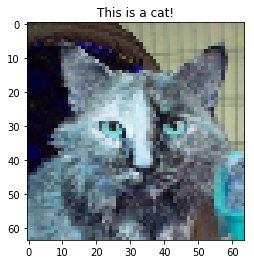

In [13]:
show_images(X_train.T, y_train.T, 2)

## Teaching our robot to group images using Logistic Regression

### What is Logistic Regression and how can it help us in this task?

Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable. This means that the input can be any number of numerical variables and the **output is binary**, for example, True or False, 0 or 1, Group A or Group B. This is why Logistic Regression can be particularly suitable here since we are trying to separate our pictures into **Cats or Dogs**.

For this activity, we are using functions from the very popular Machine Learning Python library scikit learn, often abreviated to ```sklearn```. In the code below, we use the function ```LogisticRegressionCV()``` which is helping us create the model.

In [14]:
# Here we import the library that containg our Logistic Regression function
from sklearn.linear_model import LogisticRegressionCV

In [15]:
# Here we assign the function to variable name we can call conveniently later on in out code 
clf = LogisticRegressionCV()

### Maximum number of iteration: How does it impact your model?

In [16]:
X_train_lr, y_train_lr = X_train.T, y_train.T.ravel()

**We are now ready to make all the magic happen!** Since the training dataset is huge, creating the model takes a lot of time and requires a powerful computer. The chunk of code required to do so is the following:

```clf.fit(X_train_lr, y_train_lr)```

To avoid overwelming your device, we trained Felix for you and stored the model in a **pickle** using Python's pickle module.
A pickle allows computer scientists to store complex models convenienlty to re-use later. 


<img src="https://nourishedkitchen.com/wp-content/uploads/2017/07/sour-pickles-post.jpg" style="height:300px"> 

In the next step we are ready to unpickle our work and store it under **loaded_model** to try it on our test dataset!


In [55]:
loaded_model = pickle.load(open(filename, 'rb'))

Here we can check how good Felix is at predicting images from the training folder but the real challenge will be to identify correctly the test images. We will test that later.

In [56]:
print("Model accuracy estimated at: {:.2f}%".format(loaded_model.score(X_train_lr, y_train_lr)*100))


Model accuracy estimated at: 73.32%


### Congratulations! You just trained your first image classification model!

A model accuracy of 73.32% means that out of 10 predictions you are likely to get 7 correct ones. Luckily, ```sklearn``` has a special function to help us get that number so we do not have to calculate it for ourselves.

## Testing your new model! 
### Can your robot accurately predict if this new image is from a Cat or a Dog?

In [57]:
def show_image_prediction(X, idx, model) :
  image = X[idx].reshape(1,-1)
  image_class = classes[model.predict(image).item()]
  image = image.reshape((ROWS, COLS, CHANNELS))
  plt.figure(figsize = (4,2))
  plt.imshow(image)
  plt.title("Test {} : I think this is a {}!".format(idx, image_class))
  plt.show()

### Let's have a look at a selection of test samples - are predictions correct?

The next bit of code randomly samples 10 images from the test images and applies the model. Everytime you run it, you get a new random assortment of test animals. Try it! Maybe you will spot the picture of the dog with the bunny ears.

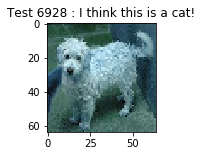

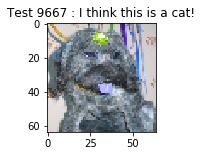

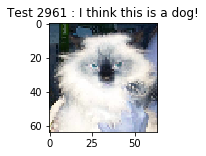

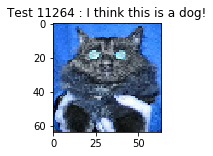

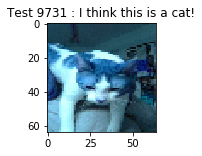

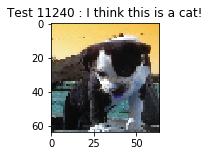

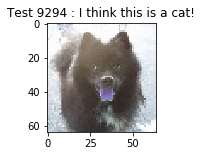

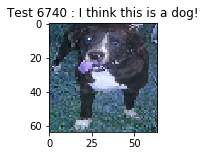

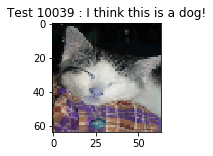

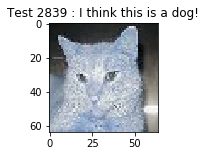

In [63]:
X_test_lr, test_idx = X_test.T, test_idx.T

for i in np.random.randint(0, len(X_test_lr), 10) :
  show_image_prediction(X_test_lr, i, loaded_model)

## Discussion Point:
### How can we improve performance?

Can you think of ways to improve how well the robot differentiates between the two types of animals?


## Bonus Activity: Try it on your own pictures!

### My family's pets

In this section, I will show you how to run the model on your own pictures. If the robot encountered you pets in the wild? Would it be able to tell the cats and dogs apart?

In folder **test2**, I include some of my family pets. Once you are ready, you can try to create your own **test2* folder or you can add pictures to this existing one and re-run both code chunks below.

Note that Kevin's picture was taken many years ago with my first phone camera (a Nokia 3200!). **Will the model still be able to make an accurate prediction?**

<img src="https://i.imgur.com/0HfdDc3.jpg" style="height:150"> 



Note: This code chunk needs to be re-run everytime you modify the **test2 folder**.

In [59]:
# Prepare new test directory pointing to folder test2
TEST_DIR2 = './test2/'

test_images2 = [TEST_DIR2+i for i in os.listdir(TEST_DIR2)]

# Process data from the new pet images folder
X_test2, test2_idx = prep_data(test_images2)

# Inspect processed dataset
print("Test shape2: {}".format(X_test2.shape))

X.shape is (12288, 17)
Proceed 0 of 17
Test shape2: (12288, 17)


Since we selct images from the folder randomly, you will notice that the same animals can come back in the same sample. Keep running this cell to discover new animals and items!

Note: This code chunk needs to be re-run everytime you modify the **test2 folder**.

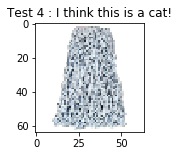

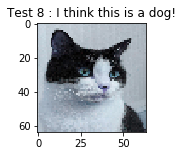

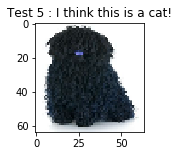

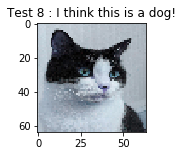

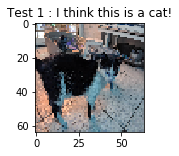

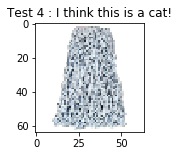

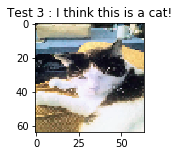

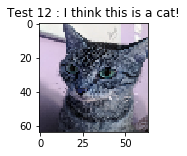

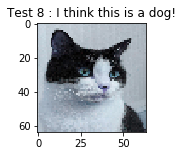

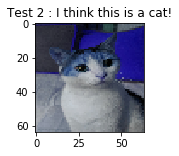

In [60]:
# Run model on new pet data
X_test2_lr, test2_idx = X_test2.T, test2_idx.T


# Show samples from new tests
for i in np.random.randint(0, len(X_test2_lr), 10) :
  show_image_prediction(X_test2_lr, i, loaded_model)

## Discussion Point:

### What kind of mistakes does Felix make? Can you spot any biases for any specific characteristics?

## Next Steps

[Recommendaton for more ressources and Computer Vision course on Mildred]